<a href="https://colab.research.google.com/github/hsinyang0816/ML2021-Colab-Code/blob/master/hw8_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 8 - Anomaly Detection**

If there are any questions, please contact ntu-ml-2021spring-ta@googlegroups.com

In [ ]:
!nvidia-smi

Mon May 17 19:58:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Mounting your gdrive (Optional)
By mounting your gdrive, you can save and manage your data and models in your Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

# your workspace in your drive
workspace = 'ML2021/HW8'


try:
  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))
except:
  os.mkdir(os.path.join('/content/gdrive/My Drive/', workspace))
  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))

Mounted at /content/gdrive


In [ ]:
!pwd

/content/gdrive/My Drive/ML2021/HW8


# Set up the environment


## Package installation

In [ ]:
# Training progress bar
!pip install -q qqdm

## Downloading data
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/15XWO-zI-AKW0igfwSydmwSGa8ENb9wCg

In [ ]:

# !gdown --id '15XWO-zI-AKW0igfwSydmwSGa8ENb9wCg' --output data-bin.tar.gz 

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id '167SejKP7vLB2sbHfQHJii8-WisYoTmLH' --output data-bin.tar.gz 

# 1
# !gdown --id '1BXJaeouaf4Zml2aeNlQfJ_AOcItTWcef' --output data-bin.tar.gz 

# 2
# !gdown --id '1HkBPxhk-9rD0H_cen2YjLXxsvInkToBl' --output data-bin.tar.gz 

# 3
# !gdown --id '1K_WGT8AD8iMsOSMYtK1Gp6vyEcRNCLQM' --output data-bin.tar.gz 

# 4
# !gdown --id '1LGdyDUQA4EPaWTEUVm_upPAEl6qAh91Z' --output data-bin.tar.gz 

# 5
# !gdown --id '1N9wNazaMy4A0UQ6pow5DXfVJ6abaiQxU' --output data-bin.tar.gz 

# 6
# !gdown --id '1PC66MrDw-tnuYN2STauPg2FoJYm3_Yy5' --output data-bin.tar.gz 

# 7
# !gdown --id '1mzy4E06CcBJc0udhPgL4zMhDlWibKbVs' --output data-bin.tar.gz 

# 8
# !gdown --id '1zPbCF7whPv1Xs_2azwe1SUweomgLsVwH' --output data-bin.tar.gz 

# 9
# !gdown --id '1Uc1Y8YYAwj7D0_wd0MeSX3szUiIB1rLU' --output data-bin.tar.gz 

## Untar data

data-bin contains 2 files
```
data-bin/
├── trainingset.npy
├── testingset.npy
...
```

In [ ]:
# !tar zxvf data-bin.tar.gz
# !ls data-bin
# !rm data-bin.tar.gz

# Import packages

In [ ]:
import numpy as np
import random
import torch

from torch.utils.data import DataLoader
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import torchvision.transforms as transforms

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from torch.optim import Adam, AdamW

from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq, kmeans

from qqdm import qqdm, format_str
import pandas as pd

import pdb  # use pdb.set_trace() to set breakpoints for debugging
from torch import Tensor



# Loading data

In [ ]:

train = np.load('data-bin/trainingset.npy', allow_pickle=True)
test = np.load('data-bin/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(140001, 64, 64, 3)
(19999, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [ ]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(19530615)

# Autoencoder

# Models & loss

Lecture video：https://www.youtube.com/watch?v=6W8FqUGYyDo&list=PLJV_el3uVTsOK_ZK5L0Iv_EQoL1JefRL4&index=8

fcn_autoencoder and vae are from https://github.com/L1aoXingyu/pytorch-beginner

conv_autoencoder is from https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder/

In [ ]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 64 * 64 * 3), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# maybe it can be smaller
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 3 * 64 * 64
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.BatchNorm2d(12),         
            nn.ReLU(),
            # 12 * 32 * 32
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  
            nn.BatchNorm2d(24),      
            nn.ReLU(),
            # 24 * 16 * 16
			      nn.Conv2d(24, 48, 4, stride=2, padding=1), 
            nn.BatchNorm2d(48),        
            nn.ReLU(),
            # 48 * 8 * 8
            # nn.Conv2d(48, 96, 4, stride=2, padding=1),   # medium: remove this layer
            # nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1), # medium: remove this layer
            # nn.ReLU(),
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.BatchNorm2d(24),  
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)  # mse loss
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD


class Resnet(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(Resnet, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)

        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        if x.shape[0] > 1:
            x = self.bn1(self.fc1(x))
        else:
            x = self.fc1(x)
        x = self.relu(x)
        if x.shape[0] > 1:
            x = self.bn2(self.fc2(x))
        else:
            x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3_mu(x)
        return x

    def decode(self, z):
        if z.shape[0] > 1:
            x = self.relu(self.fc_bn4(self.fc4(z)))
            x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        else:
            x = self.relu(self.fc4(z))
            x = self.relu(self.fc5(x)).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=True)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_reconst = self.decode(z)

        return x_reconst

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.BatchNorm2d(12),         
            nn.LeakyReLU(0.2),
            # 12 * 32 * 32
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  
            nn.BatchNorm2d(24),      
            nn.LeakyReLU(0.2),
            # 24 * 16 * 16
            nn.Conv2d(24, 48, 4, stride=2, padding=1), 
            nn.BatchNorm2d(48),        
            nn.LeakyReLU(0.2),
            # 48 * 8 * 8
            nn.Conv2d(48, 96, 4, stride=2, padding=1), 
            nn.BatchNorm2d(96),        
            nn.Tanh(),
            # 96 * 4 * 4

        )
        
    def forward(self, input):
        output = self.encoder(input)
        # output = torch.sigmoid(output)
        # print(output.shape)
        # output = output.view(output.size(0), -1)
        return output

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            # 96 * 4 * 4
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1), 
            nn.BatchNorm2d(48),  
            nn.LeakyReLU(0.2),
            # 48 * 8 * 8
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.BatchNorm2d(24),  
            nn.LeakyReLU(0.2),
            # 24 * 16 * 16
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.BatchNorm2d(12),
            nn.LeakyReLU(0.2),
            # 12 * 32 * 32
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            # 3 * 64 * 64
        )
        
    def forward(self, input):
        # output = input.view(input.size(0),96,4,4)
        output = self.decoder(input)
        return output

class disc_latent(nn.Module):
    """
    DISCRIMINATOR latent NETWORK
    """

    def __init__(self):
        super(disc_latent, self).__init__()
        self.dense_1 = nn.Linear(3072, 1024)
        self.batch_norm_1 = nn.BatchNorm1d(1024)

        self.dense_2 = nn.Linear(1024, 256)
        self.batch_norm_2 = nn.BatchNorm1d(256)

        self.dense_3 = nn.Linear(256, 64)
        self.batch_norm_3 = nn.BatchNorm1d(64)

        self.dense_4 = nn.Linear(64, 16)
        self.batch_norm_4 = nn.BatchNorm1d(16)

        self.dense_5 = nn.Linear(16, 1)
    

    def forward(self, input):
        # print(self.dense_1(input).shape,22222222222222222222222222222222222)
        output = input.view(input.size(0),-1)

        output = self.batch_norm_1(self.dense_1(output))
        output = F.relu(output)
        
        output = self.batch_norm_2(self.dense_2(output))
        output = F.relu(output)

        output = self.batch_norm_3(self.dense_3(output))
        output = F.relu(output)

        output = self.batch_norm_4(self.dense_4(output))
        output = F.relu(output)

        output = self.dense_5(output)
        # print(output.shape,11111111111111111111111111111)
        output = torch.sigmoid(output)

        return output

class disc_visual(nn.Module):
    """
    DISCRIMINATOR vision  NETWORK
    """

    def __init__(self):
        super(disc_visual, self).__init__()
        self.conv1 = nn.Conv2d(3,16,4,stride=2,padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(16)
        self.leaky_relu = nn.LeakyReLU(0.2)

        self.conv2 = nn.Conv2d(16,16,4,stride=2,padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16,16,4,stride=2,padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(16)
                
        self.conv4 = nn.Conv2d(16,1,4,stride=2,padding=1)
        self.conv5 = nn.AdaptiveAvgPool2d(output_size=1)
        # self.sigmoid = torch.sigmoid()

    def forward(self, input):

        output = self.batch_norm_1(self.conv1(input))
        output = self.leaky_relu(output)

        output = self.batch_norm_2(self.conv2(output))
        output = self.leaky_relu(output)

        output = self.batch_norm_3(self.conv3(output))
        output = self.leaky_relu(output)

        output = self.conv4(output)
        output = torch.sigmoid(self.conv5(output))
        output = output.view(output.size(0), -1)

        return output

class Classifier(nn.Module):
    """
    Classfier NETWORK
    """

    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3,12,4,stride=2,padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(12)
        self.leaky_relu = nn.LeakyReLU(0.2)

        self.conv2 = nn.Conv2d(12,24,4,stride=2,padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(24)

        self.conv3 = nn.Conv2d(24,48,4,stride=2,padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(48)
                
        self.conv4 = nn.Conv2d(48,1,4,stride=2,padding=1)
        self.conv5 = nn.AdaptiveAvgPool2d(output_size=1)
        # self.sigmoid = torch.sigmoid()
        


    def forward(self, input):
        output = self.batch_norm_1(self.conv1(input))
        output = self.leaky_relu(output)

        output = self.batch_norm_2(self.conv2(output))
        output = self.leaky_relu(output)

        output = self.batch_norm_3(self.conv3(output))
        output = self.leaky_relu(output)

        output = self.conv4(output)

        output = torch.sigmoid(self.conv5(output))
        output = output.view(-1)


        return output

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [ ]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
                            transforms.Lambda(lambda x: x.to(torch.float32)),
                            transforms.Lambda(lambda x: 2. * x/255. - 1.),
                            # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Initialize
- hyperparameters
- dataloader
- model
- optimizer & loss


In [ ]:
# Training hyperparameters
num_epochs = 900
batch_size = 4096 # medium: smaller batchsize
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
# model_type = 'cnn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
# model_classes = {'resnet': Resnet(), 'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), }
# model = model_classes[model_type].cuda()

encoder = Encoder().cuda()
decoder = Decoder().cuda()
classifier = Classifier().cuda()
# Dv = disc_visual().cuda()
# Dl = disc_latent().cuda()

# Loss and optimizer
criterion_ce = nn.BCELoss().cuda()
criterion_ae = nn.MSELoss().cuda()

l2_int=torch.empty(size=(batch_size, 3072,1,1), dtype=torch.float32)

optimizer_en = Adam(encoder.parameters(), lr=learning_rate, betas=(0.9, 0.99))
optimizer_de = Adam(decoder.parameters(), lr=learning_rate, betas=(0.9, 0.99))
# optimizer_dl = Adam(Dl.parameters(), lr=learning_rate, betas=(0.9, 0.99))
# optimizer_dv = Adam(Dv.parameters(), lr=learning_rate, betas=(0.9, 0.99))
optimizer_c = Adam(classifier.parameters(), lr=learning_rate, betas=(0.9, 0.99))
# optimizer_l2 = Adam([{'params':l2_int}], lr=learning_rate, betas=(0.9, 0.99))

## Training loop

In [ ]:
best_loss = np.inf
encoder.train()
decoder.train()
classifier.train()
# Dv.train()
# Dl.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    if epoch < 850 :
        tot_loss = list()
        for data in train_dataloader:

            # ===================loading=====================
            img = data.float().cuda()

            # ===================forward=====================
            n = torch.randn(img.shape[0], 3, 64, 64).cuda()
            z_dim = encoder(img + n)
            # print(output.shape)
            output = decoder(z_dim)
            # print(output.shape)
            loss = criterion_ae(output, img)

            tot_loss.append(loss.item())
            # ===================backward====================
            optimizer_en.zero_grad()
            optimizer_de.zero_grad()
            loss.backward()
            optimizer_en.step()
            optimizer_de.step()
        # ===================save_best====================
        mean_loss = np.mean(tot_loss)
        if mean_loss < best_loss:
            best_loss = mean_loss
            torch.save(encoder, 'best_model_encoder.pt')
            torch.save(decoder, 'best_model_decoder.pt')
        # ===================log========================
        qqdm_train.set_infos({
          'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
          'loss': f'{mean_loss:.4f}',
        })
        # ===================save_last========================
        torch.save(encoder, 'last_model_encoder.pt')
        torch.save(decoder, 'last_model_decoder.pt')
    else :
        tot_loss = list()
        cl_loss = list()
        for data in train_dataloader:

            # ===================loading=====================
            img = data.float().cuda()
            bs = img.shape[0]
            # ===================forward=====================
            # z = Variable(torch.randn(bs, 96 * 4 * 4)).cuda()
            # z = Variable(torch.randn(bs, 96, 4, 4)).cuda()
            z = Variable(2 * torch.rand(bs, 96, 4, 4) - 1).cuda()
            dec_fake = decoder(z) # decode fake img


            n = torch.randn(bs, 3, 64, 64).cuda()
            z_with_gaussion = encoder(img + n)
            # print(output.shape)
            dec_real = decoder(z_with_gaussion) # decode train img
            # print(output.shape)

            # ===================classifier=====================
            # print(dec_l1.shape)
            r_logits = classifier(dec_real)
            # print(logits_C_l1.shape)
            f_logits = classifier(dec_fake)

            r_label = torch.ones((bs)).cuda()
            f_label = torch.zeros((bs)).cuda()

            r_loss = criterion_ce(r_logits,r_label)
            f_loss = criterion_ce(f_logits,f_label)

            loss_cl = (r_loss + f_loss) / 2
            classifier.zero_grad()
            loss_cl.backward(retain_graph=True)
            optimizer_c.step()

            # ===================latent discriminater=====================
            # disc_l_l1 = l1.view(l1.size(0),48,8,8)
            # Dl.zero_grad()
            # logits_Dl_l1 = Dl(disc_l_l1)
            # logits_Dl_l2 = Dl(l2)
            # dl_logits_DL_l1 = Variable(Tensor(logits_Dl_l1.shape[0], 1).fill_(0.0), requires_grad=False).cuda()
            # dl_logits_DL_l2 = Variable(Tensor(logits_Dl_l2.shape[0], 1).fill_(1.0), requires_grad=False).cuda()
    
            # loss_dl_1 = criterion_ce(logits_Dl_l1 , dl_logits_DL_l1)
            # loss_dl_2 = criterion_ce(logits_Dl_l2 , dl_logits_DL_l2)
            # loss_dl = (loss_dl_1 + loss_dl_2) / 2

            
            # loss_dl.backward(retain_graph=True)
            # optimizer_dl.step()

            # ===================visual discriminater=====================
            # logits_Dv_X = Dv(img)
            # logits_Dv_l2 = Dv(dec_l2)


            # dv_logits_Dv_X = Variable(Tensor(logits_Dv_X.shape[0], 1).fill_(1.0), requires_grad=False).cuda()
            # dv_logits_Dv_l2 = Variable(Tensor(logits_Dv_l2.shape[0], 1).fill_(0.0), requires_grad=False).cuda()
            
            # loss_dv_1 = criterion_ce(logits_Dv_X,dv_logits_Dv_X)
            # loss_dv_2 = criterion_ce(logits_Dv_l2,dv_logits_Dv_l2)
            # loss_dv = (loss_dv_1 + loss_dv_2) / 2

            # Dv.zero_grad()
            # loss_dv.backward(retain_graph=True)
            # optimizer_dv.step()

            # l2
            # for i in range(5):
            #     logits_C_l2_mine = classifier(dec_l2)
            #     zeros_logits_C_l2_mine = Variable(Tensor(logits_C_l2_mine.shape[0], 1).fill_(0.0), requires_grad=False).cuda()
            #     loss_C_l2_mine = criterion_ce(logits_C_l2_mine,zeros_logits_C_l2_mine)
            #     optimizer_l2.zero_grad()
            #     loss_C_l2_mine.backward(retain_graph=True)
            #     optimizer_l2.step()

            ######  update ae 
            # out_gv1 = Dv(dec_l2)
            # z = Variable(torch.randn(bs, 3072)).cuda()
            # f_imgs = decoder(z)
            # f_logit = classifier(f_imgs)
            # loss_decoder = criterion_ce(f_logit, r_label)

            # Xh = decoder(l1)
            # Xh_cl = classifier(Xh)
            # label_logits_Xh_cl = Variable(Tensor(Xh_cl.shape[0], 1).fill_(1.0), requires_grad=False).cuda()
            # loss_label = criterion_ce(Xh_cl,label_logits_Xh_cl)
            loss_mse = criterion_ae(dec_real,img)
            # ones_logits_Dl_l1 = Variable(Tensor(logits_Dl_l1.shape[0], 1).fill_(1.0), requires_grad=False).cuda()
    
            # loss_AE_l = criterion_ce(logits_Dl_l1,ones_logits_Dl_l1)

            # logits_Dv_l2_mine = Dv(dec_l2)
            # ones_logits_Dv_l2_mine = Variable(Tensor(logits_Dv_l2_mine.shape[0], 1).fill_(1.0), requires_grad=False).cuda()
            # loss_ae_v = criterion_ce(logits_Dv_l2_mine,ones_logits_Dv_l2_mine)

            # loss_ae_all = 10*loss_mse + loss_ae_v + loss_AE_l

            encoder.zero_grad()
            decoder.zero_grad()
            # loss_ae_all.backward()
            # loss_decoder.backward(retain_graph=True)
            loss_mse.backward()
            
            optimizer_en.step()
            optimizer_de.step()
            tot_loss.append(loss_mse.item())
            cl_loss.append(loss_cl.item())

        # ===================save_best====================
        mean_loss = np.mean(tot_loss)
        mean_cl_loss = np.mean(cl_loss)
        if mean_loss < best_loss:
            best_loss = mean_loss
            torch.save(encoder, 'best_model_encoder.pt')
            torch.save(decoder, 'best_model_decoder.pt')
        # ===================log========================
        qqdm_train.set_infos({
          'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
          'loss': f'{mean_loss:.4f}',
          'classifier_loss': f'{mean_cl_loss:.4f}',
        })
        # ===================save_last========================
        torch.save(encoder, 'last_model_encoder.pt')
        torch.save(decoder, 'last_model_decoder.pt')
        torch.save(classifier, 'last_model_classifier.pt')


 Iters    Elapsed Time      Speed                                               
 0/900          -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 1/900  00:00:31<07:49:47  0.03it/s  1/900  0.2749                              
Description   0.1% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 2/900  00:01:00<07:31:40  0.03it/s  2/900  0.1019                              
Description   0.2% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 3/900  00:01:29<07:24:44  0.03it/s  3/900  0.0775                              
Description   0.3% |                                                           | Iters    Elapsed Time      Spee

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [ ]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path_enc = 'last_model_encoder.pt'
checkpoint_path_dec = 'last_model_decoder.pt'
checkpoint_path_cl = 'last_model_classifier.pt'
encoder = torch.load(checkpoint_path_enc)
decoder = torch.load(checkpoint_path_dec)
classifier = torch.load(checkpoint_path_cl)
encoder.eval()
decoder.eval()
classifier.eval()

# prediction file 
out_file = 'PREDICTION_FILE.csv'

In [ ]:
import math    
anomality = list()
k = 0
j = 0
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
        img = data.float().cuda() 
        # if model_type in ['cnn', 'vae', 'resnet']:
        #     img = data.float().cuda()
        # elif model_type in ['fcn']:
        #     img = data.float().cuda()
        #     img = img.view(img.shape[0], -1)
        # else:
        #     img = data[0].cuda()
        output = encoder(img)
        output = decoder(output)
        logits = classifier(img)
        print(logits)
        # if model_type in ['cnn', 'resnet', 'fcn']:
        #     output = output
        # elif model_type in ['res_vae']:
        #     output = output[0]
        # elif model_type in ['vae']: # , 'vqvae'
        #     output = output[0]
        loss = eval_loss(output, img).sum([1, 2, 3])
        for i in range(len(logits)):
          if logits[i] > 0.5:
            k = k + 1
          else:
            j = j + 1
          logit = 1 - logits[i]
          # loss[i] = loss[i] * math.exp(logit)
          loss[i] = loss[i] * logit
        # print(loss.shape)
        # print(loss)
        # if model_type in ['fcn']:
        #     loss = eval_loss(output, img).sum(-1)
        # else:
        #     loss = eval_loss(output, img).sum([1, 2, 3])
        anomality.append(loss)
anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['Predicted'])
df.to_csv(out_file, index_label = 'Id')
print(k)
print(j)


tensor([1.0989e-02, 2.0876e-03, 9.9657e-01, 5.2749e-01, 4.6001e-03, 9.3045e-03,
        9.3224e-01, 1.4563e-02, 6.8479e-01, 6.5177e-01, 1.7245e-02, 1.5442e-02,
        1.3424e-02, 2.2767e-03, 1.4963e-01, 9.1762e-01, 9.8323e-01, 8.7872e-01,
        1.1872e-02, 1.4734e-02, 1.5615e-01, 7.9736e-01, 9.9216e-01, 9.9928e-01,
        6.6691e-01, 4.2220e-01, 9.4016e-03, 7.6482e-03, 4.3435e-01, 1.5911e-01,
        1.4905e-01, 9.6166e-01, 8.8628e-01, 2.2090e-01, 2.3315e-02, 9.9779e-01,
        4.3141e-02, 1.7757e-03, 1.9530e-01, 3.4982e-01, 1.8142e-02, 8.7338e-01,
        5.1707e-02, 2.6258e-02, 1.1217e-01, 8.9927e-03, 8.8586e-01, 3.3505e-02,
        9.9863e-01, 9.9849e-01, 9.0558e-01, 1.2318e-01, 1.5903e-02, 4.0697e-03,
        9.9039e-01, 3.2840e-01, 9.8407e-01, 5.4093e-04, 5.7098e-02, 9.9885e-01,
        3.2731e-01, 1.7823e-01, 1.9015e-03, 1.9318e-04, 7.7626e-03, 9.5635e-01,
        8.1979e-01, 6.3721e-01, 9.4866e-01, 8.5044e-01, 7.3891e-01, 7.7492e-02,
        9.9876e-01, 9.8915e-01, 2.7442e-

# Training statistics
- Number of parameters
- Training time on colab
- Training curve of the bossbaseline model

- Simple
 - Number of parameters: 3176419
 - Training time on colab: ~ 30 min
- Medium
 - Number of parameters: 47355
 - Training time on colab: ~ 30 min
- Strong
 - Number of parameters: 47595
 - Training time on colab:  4 ~ 5 hrs
- Boss:  
 - Number of parameters: 4364140
 - Training time on colab: 1.5~3 hrs

 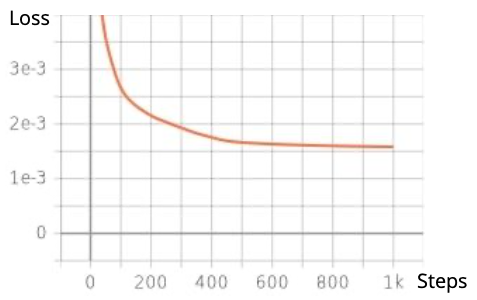


**Reference**

1.https://arxiv.org/abs/1903.08550

2.https://ieeexplore.ieee.org/document/9059022

3.https://github.com/xiehousen/OCGAN-Pytorch

4.https://github.com/nuclearboy95/Anomaly-Detection-OCGAN-tensorflow